In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotnine as p9


#  1 样本数据检查及前处理
## 1.1 样本数据检查

In [86]:
# 0 整理样本数据与样本信息
rawdata = pd.read_csv("../data/WOSP22061-result/2-Input/Protein_Matrix.csv", header=0, index_col=0)
rawinfo = pd.read_csv("../data/WOSP22061-result/2-Input/wosp22061single_sample_info.csv", header=0, index_col=0)

rawinfo = rawinfo.loc[rawdata.columns, ["Sample.Name", "Label", "Batch", "Source"]]
rawinfo.columns = ["ID", "Region", "Batch", "Hemi"]
rawinfo["Batch"] = "Batch" + rawinfo["Batch"].astype("str")
rawinfo["Region"] = [ str(i)[:-1] for i in rawinfo["Region"] ]
rawinfo["Group"] = [ i[0]+"-"+j for i, j in zip(rawinfo["Hemi"], rawinfo["Region"])]
rawinfo["Name"] = rawinfo["Region"] + "-" + rawinfo["ID"]

rawdata.columns = rawinfo.loc[rawdata.columns, "ID"]
rawinfo.set_index("ID", inplace=True)
rawdata.shape, rawinfo.shape

((6419, 56), (56, 5))

In [87]:
# 1 check NA value distribution
na_idx = rawdata.isna()

## 每个蛋白的缺失值比例
protein_NA_ratio = pd.DataFrame(na_idx.sum(axis=1) / rawdata.shape[1], columns=["Ratio"])
protein_NA_ratio.reset_index(inplace=True)

## 每个样本的缺失值比例
sample_NA_ratio = pd.DataFrame(na_idx.sum(axis=0) / rawdata.shape[0], columns=["Ratio"])

## 统计样本中的缺失比例高低是否存在 脑区 或 批次 的偏好性
tmp = []
for i in ["Region", "Batch"]:
    b1 = sample_NA_ratio.copy()
    if i == "Region":
        b1["Group"] = [ str(j)[0] +"-"+k for j, k in zip(rawinfo.loc[b1.index, "Hemi"], rawinfo.loc[b1.index, i]) ]
        b1.sort_values(by=["Group", "ID"], inplace=True)
        b1["Type"] = "Hemi-Region"
        b1["Name"] = rawinfo.loc[b1.index, i] + "-" + b1.index
    else:
        b1["Group"] = rawinfo.loc[b1.index, i]
        b1.sort_values(by=["Group", "ID"], inplace=True)
        b1["Type"] = i
        b1["Name"] = b1["Group"] + "-" + b1.index
    tmp.append(b1.copy())
sample_NA_ratio = pd.concat(tmp, axis=0)

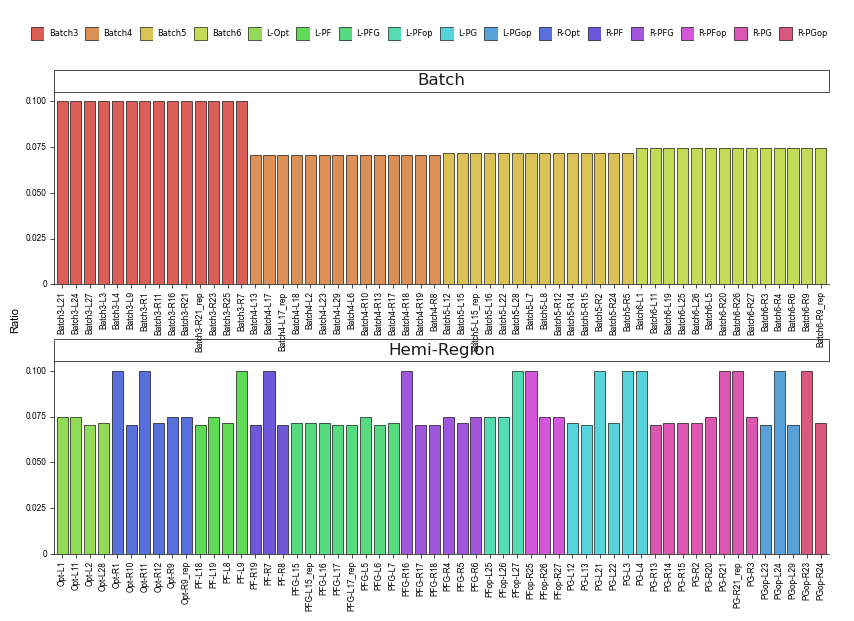

<ggplot: (8765669860602)>

In [88]:
barplot = ( p9.ggplot(p9.aes(x="Name", y="Ratio", fill="Group"), sample_NA_ratio) 
  + p9.geom_bar(stat="identity", color="black", size=0.25, width=0.8)
  + p9.theme_classic()
  + p9.scale_y_continuous(expand = [0, 0, 0.05, 0])
  + p9.theme(figure_size=(10, 6),
              axis_text = p9.element_text(color="black", size=6, family="Arial"),
              axis_text_x = p9.element_text(angle=90),
              axis_title=p9.element_text(color="black", size=8, family="Arial"),
              axis_title_x = p9.element_blank(),
              axis_line = p9.element_line(size=0.5),
              axis_ticks = p9.element_line(color="black", size=0.5),
              axis_ticks_minor_y=p9.element_blank(),
              
              legend_title=p9.element_blank(),
              legend_text=p9.element_text(color="black", size=6),
              legend_key_size=10,
              legend_background=p9.element_blank(),
              legend_direction="horizontal",
              legend_position="top",
              strip_background=p9.element_rect(size=0.5),
              strip_text=p9.element_text(size=12),
              subplots_adjust={"hspace":0.4})
  + p9.guides(fill=p9.guide_legend(nrow=1, byrow=True))
  + p9.facet_wrap("~Type", nrow=3, ncol=1, scales="free_x")
)
p9.ggsave(barplot, "../res/0.preprocessing/0.sample_NA_ratio.pdf", width=10, height=7, verbose=False )
barplot

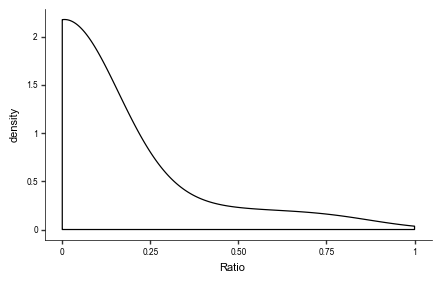

<ggplot: (8765668949721)>

In [89]:
density_plot = ( p9.ggplot(p9.aes(x="Ratio"), protein_NA_ratio) 
  + p9.geom_density()
  + p9.theme_classic()
  + p9.xlim(0, 1)
  + p9.theme(figure_size=(5, 3),
              axis_text = p9.element_text(color="black", size=6, family="Arial"),
              axis_title=p9.element_text(color="black", size=8, family="Arial"),
              axis_line = p9.element_line(size=0.5),)
)
p9.ggsave(density_plot, "../res/0.preprocessing/0.protein_NA_ratio_density.pdf", width=5, height=3, verbose=False )
density_plot

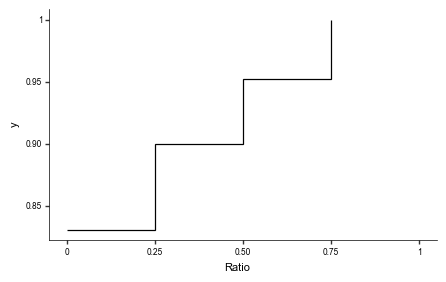

<ggplot: (8765669680189)>

In [90]:
density_plot = ( p9.ggplot(p9.aes(x="Ratio"), protein_NA_ratio) 
  + p9.stat_ecdf()
  + p9.theme_classic()
  + p9.xlim(0, 1)
  + p9.theme(figure_size=(5, 3),
              axis_text = p9.element_text(color="black", size=6, family="Arial"),
              axis_title=p9.element_text(color="black", size=8, family="Arial"),
              axis_line = p9.element_line(size=0.5),)
)
p9.ggsave(density_plot, "../res/0.preprocessing/0.protein_NA_ratio_cdf.pdf", width=5, height=3, verbose=False )
density_plot

In [91]:
protein_NA_ratio.shape, (protein_NA_ratio["Ratio"] >= 0.5).sum()

((6419, 2), 642)

## 1.2 样本前处理

In [92]:
# 1. 去除缺失比例>=50%的蛋白
na_thr = 0.5
prot_idx = rawdata.isna().sum(axis=1)/rawdata.shape[1] < na_thr
cleandata_filt_na_prot = rawdata.loc[prot_idx, :]
cleandata_filt_na_prot.shape

(5777, 56)

In [93]:
# 2. Median normalization
#cleandata_median_norm = cleandata_filt_na_prot / cleandata_filt_na_prot.median(axis=0, skipna=True)
cleandata_median_norm = cleandata_filt_na_prot.copy()

In [94]:
# 3. check CV: 都符合样本CV取值的范围要求
group_mean = cleandata_median_norm.T.groupby(by=rawinfo["Group"]).mean()
group_std = cleandata_median_norm.T.groupby(by=rawinfo["Group"]).std(ddof=0)
group_cv = (group_std / group_mean).T.melt(value_name="CV", var_name="Group")

/mnt/d/workdir_for_Linux/software/Miniconda3/envs/proteomics/lib/python3.8/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_ydensity : Removed 38 rows containing non-finite values.
/mnt/d/workdir_for_Linux/software/Miniconda3/envs/proteomics/lib/python3.8/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_boxplot : Removed 38 rows containing non-finite values.
/mnt/d/workdir_for_Linux/software/Miniconda3/envs/proteomics/lib/python3.8/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_ydensity : Removed 38 rows containing non-finite values.
/mnt/d/workdir_for_Linux/software/Miniconda3/envs/proteomics/lib/python3.8/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_boxplot : Removed 38 rows containing non-finite values.


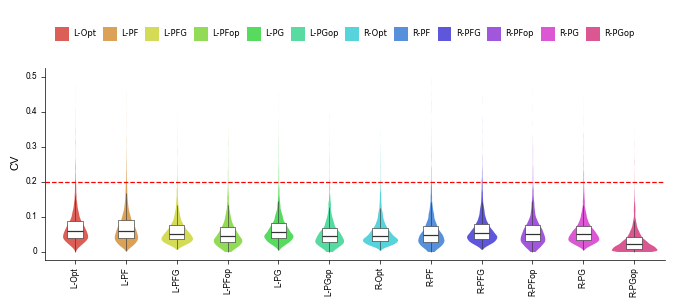

<ggplot: (8765669747577)>

In [95]:
violin_plot = (p9.ggplot(p9.aes(x="Group", y="CV", ), group_cv)
  + p9.geom_violin(p9.aes(fill="Group"), color=None)
  + p9.geom_boxplot( width=0.3, size=0.25, outlier_shape=None, outlier_alpha=0)
  + p9.geom_hline(yintercept=0.2, color="red", linetype="dashed", size=0.5)
  + p9.ylim(0, 0.5)
  + p9.theme_classic()
  + p9.theme(figure_size=(8, 2.5),
              axis_text = p9.element_text(color="black", size=6, family="Arial"),
              axis_text_x = p9.element_text(angle=90),
              axis_title=p9.element_text(color="black", size=8, family="Arial"),
              axis_title_x = p9.element_blank(),
              axis_line = p9.element_line(size=0.5),
              axis_ticks = p9.element_line(color="black", size=0.5),
              axis_ticks_minor_y=p9.element_blank(),
              
              legend_title=p9.element_blank(),
              legend_text=p9.element_text(color="black", size=6),
              legend_key_size=10,
              legend_background=p9.element_blank(),
              legend_direction="horizontal",
              legend_position="top",
              strip_background=p9.element_rect(size=0.5),
              strip_text=p9.element_text(size=12),
              subplots_adjust={"hspace":0.4})
  + p9.guides(fill=p9.guide_legend(nrow=1, byrow=True))
)
p9.ggsave(violin_plot, "../res/0.preprocessing/0.group_cv.pdf", width=8, height=2.5, verbose=False )
violin_plot

In [96]:
group_cv_pass_ratio = ((group_std / group_mean).T < 0.2).sum(axis=0)/cleandata_median_norm.shape[0]
group_cv_median = (group_std / group_mean).T.median(axis=0, skipna=True)
pd.concat([group_cv_pass_ratio, group_cv_median], axis=1)

,0,1
Group,,
L-Opt,0.976458,0.059366
L-PF,0.972131,0.058736
L-PFG,0.981998,0.050431
L-PFop,0.986152,0.043000
L-PG,0.979747,0.054967
L-PGop,0.988922,0.043248
R-Opt,0.988748,0.044653
R-PF,0.983209,0.045909
R-PFG,0.983729,0.052827


In [97]:
## 4. log transformation
cleandata_log_trans =  np.log2(cleandata_median_norm)

In [98]:
violin_dat = cleandata_log_trans.melt(var_name="ID", value_name="Expr")
violin_dat = violin_dat.loc[~violin_dat["Expr"].isna(), :]
violin_dat["Group"] = rawinfo["Group"].loc[violin_dat["ID"]].values
violin_dat["Name"] = rawinfo["Name"].loc[violin_dat["ID"]].values
violin_dat.sort_values(by=["Group", "Name"], inplace=True)

/mnt/d/workdir_for_Linux/software/Miniconda3/envs/proteomics/lib/python3.8/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_ydensity : Removed 1621 rows containing non-finite values.
/mnt/d/workdir_for_Linux/software/Miniconda3/envs/proteomics/lib/python3.8/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_boxplot : Removed 1621 rows containing non-finite values.
/mnt/d/workdir_for_Linux/software/Miniconda3/envs/proteomics/lib/python3.8/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_ydensity : Removed 1621 rows containing non-finite values.
/mnt/d/workdir_for_Linux/software/Miniconda3/envs/proteomics/lib/python3.8/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_boxplot : Removed 1621 rows containing non-finite values.


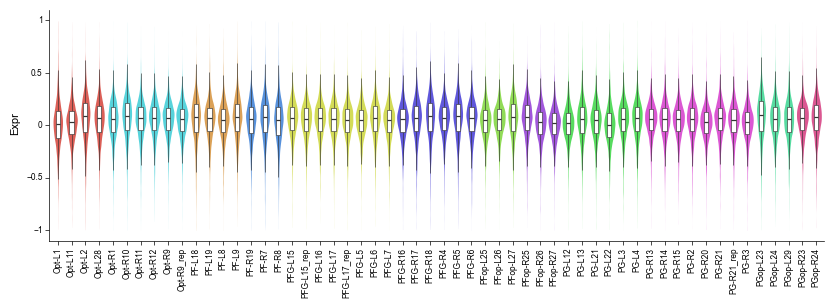

<ggplot: (8765668371360)>

In [99]:
violin_plot = (p9.ggplot(p9.aes(x="Name", y="Expr", ), violin_dat)
  + p9.geom_violin(p9.aes(fill="Group"), color=None)
  + p9.geom_boxplot( width=0.3, size=0.25, outlier_shape=None, outlier_alpha=0)
  + p9.theme_classic()
  + p9.ylim(-1, 1)
  + p9.theme(figure_size=(10, 3),
              axis_text = p9.element_text(color="black", size=6, family="Arial"),
              axis_text_x = p9.element_text(angle=90),
              axis_title=p9.element_text(color="black", size=8, family="Arial"),
              axis_title_x = p9.element_blank(),
              axis_line = p9.element_line(size=0.5),
              axis_ticks = p9.element_line(color="black", size=0.5),
              axis_ticks_minor_y=p9.element_blank(),
              
              legend_title=p9.element_blank(),
              legend_text=p9.element_text(color="black", size=6),
              legend_key_size=10,
              legend_background=p9.element_blank(),
              legend_direction="horizontal",
              legend_position="top",
              strip_background=p9.element_rect(size=0.5),
              strip_text=p9.element_text(size=12),
              subplots_adjust={"hspace":0.4})
  + p9.guides(fill=False)
)
p9.ggsave(violin_plot, "../res/0.preprocessing/0.sample_violin.pdf", width=8, height=2.5, verbose=False )
violin_plot

In [100]:
## 5. evaluate NA imputation method and impute NA
import utils
from sklearn import preprocessing
from sklearn.decomposition import PCA
from scipy.spatial import procrustes

## 评价准则参考了NAguideR方法中的PSS以及ACC_PPI

### 过滤含有缺失值的protein后，计算PCA
cleandata_filt_all_na = cleandata_log_trans.loc[ cleandata_log_trans.isna().sum(axis=1) == 0, :]
pca_obj = PCA(n_components=3)
#cleandata_pca = pca_obj.fit_transform(preprocessing.scale(cleandata_filt_all_na.T, axis=0))
cleandata_pca = pca_obj.fit_transform(cleandata_filt_all_na.T)

### load gene symbol of clusters
prot_clusters = { }
for line in open("../data/STRING_macaque/macaque_prot_cluster.txt"):
    cluster_id, genes = line.strip().split("\t")
    prot_clusters[cluster_id] = set(genes.split(","))

eval_k = list(range(10, 50, 3))
m2 = []
acc_ppi = []
spearman = []
for k in eval_k:
    ### 使用seq KNN方法impute NA值
    tmp = utils.seq_KNN(cleandata_log_trans, k=k)

    ### Procrustes Analysis (PSS)方法评估缺失值填充
    #tmp_pca = pca_obj.fit_transform(preprocessing.scale(tmp.T, axis=0))
    tmp_pca = pca_obj.fit_transform(tmp.T)
    m2.append( procrustes(tmp_pca, cleandata_pca)[2] )
    
    ### ACC_PPI
    acc_ppi.append(0)
    for cluster_id in prot_clusters:
        isin_cluster = pd.Series(tmp.index).str.split("_", expand=True).set_index(tmp.index)[1].isin(prot_clusters[cluster_id])
        acc_ppi[-1] += np.triu(tmp.loc[isin_cluster].corr(method="pearson"), k=1).mean()
    acc_ppi[-1] /= len(prot_clusters)

    ### technical replicate
    spearman.append(0)
    for idx_i, idx_j in zip([7, 22, 34, 45], [13, 27, 41, 55]):
        select_prot_idx = (cleandata_log_trans.iloc[:, idx_i].isna() | cleandata_log_trans.iloc[:, idx_j].isna())
        spearman[-1] += pd.DataFrame(tmp.iloc[:, idx_i].loc[select_prot_idx]).corrwith(tmp.iloc[:, idx_j].loc[select_prot_idx], method="spearman").values[0]
    spearman[-1] /= 4


In [101]:
plot_dat = pd.DataFrame([eval_k, m2, acc_ppi, spearman]).T
plot_dat.columns = ["k", "M2", "ACC_PPI", "R2"]
plot_dat = plot_dat.iloc[:, 1:].melt(var_name="Group", value_name="Value")
plot_dat["Group"] = pd.Categorical(plot_dat["Group"], categories=["M2", "ACC_PPI", "R2"])
plot_dat['K'] = eval_k * 3

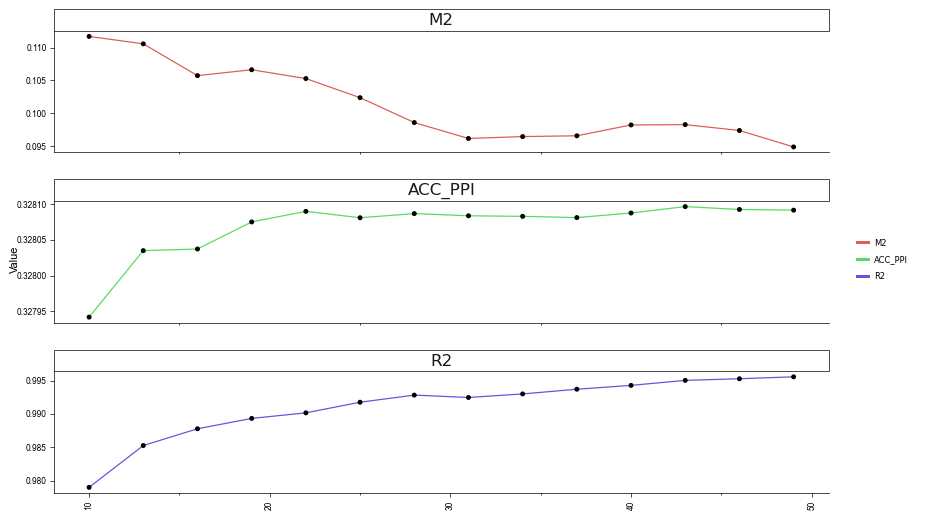

<ggplot: (8765668091615)>

In [102]:
lineplot = ( p9.ggplot(p9.aes(x="K", y="Value", color="Group"), plot_dat)
  + p9.geom_line()
  + p9.geom_point(color="black", size=1)
  + p9.theme_classic()
  #+ p9.scale_y_continuous(expand = [0, 0, 0.05, 0])
  + p9.theme(figure_size=(10, 6),
              axis_text = p9.element_text(color="black", size=6, family="Arial"),
              axis_text_x = p9.element_text(angle=90),
              axis_title=p9.element_text(color="black", size=8, family="Arial"),
              axis_title_x = p9.element_blank(),
              axis_line = p9.element_line(size=0.5),
              axis_ticks = p9.element_line(color="black", size=0.5),
              axis_ticks_minor_y=p9.element_blank(),
              
              legend_title=p9.element_blank(),
              legend_text=p9.element_text(color="black", size=6),
              legend_key_size=10,
              legend_background=p9.element_blank(),
              legend_direction="vertical",
              legend_position="right",
              strip_background=p9.element_rect(size=0.5),
              strip_text=p9.element_text(size=12),
              subplots_adjust={"hspace":0.4})
  + p9.guides(fill=p9.guide_legend(nrow=1, byrow=True))
  + p9.facet_wrap("~Group", nrow=3, ncol=1, scales="free_y")
)
p9.ggsave(lineplot, "../res/0.preprocessing/0.imputation_estimation.pdf", width=10, height=6, verbose=False )
lineplot


In [103]:
cleandata_impute_na = utils.seq_KNN(cleandata_log_trans, k=30)
cleandata_impute_na.shape

(5777, 56)

In [104]:
## 6. 去除无基因名称的行，合并重复基因名的行
gene_symbol = pd.Series(cleandata_impute_na.index).str.split("_", expand=True)[1]
gene_symbol.index = cleandata_impute_na.index
cleandata_remove_na_gene = cleandata_impute_na.loc[gene_symbol != "", :]
cleandata_remove_na_gene.shape

(5715, 56)

In [105]:
## 7. 合并重复基因名的行
gene_symbol = pd.Series(cleandata_remove_na_gene.index).str.split("_", expand=True)[1].values
cleandata_merge_repeat_gene = cleandata_remove_na_gene.groupby(gene_symbol).median()
cleandata_merge_repeat_gene.shape

(5542, 56)

In [106]:
cleandata_merge_repeat_gene.to_csv("../res/0.preprocessing/sample_expr.tsv", sep="\t")
rawinfo.to_csv("../res/0.preprocessing/sample_info.tsv", sep="\t")

In [107]:
rawinfo.loc[:, ["Region", "Hemi"]].value_counts().sort_index()

Region  Hemi 
Opt     Left     4
        Right    6
PF      Left     4
        Right    3
PFG     Left     8
        Right    6
PFop    Left     3
        Right    3
PG      Left     6
        Right    8
PGop    Left     3
        Right    2
dtype: int64

In [108]:
rawinfo.loc[:, ["Region", "Hemi"]].value_counts().sort_index().sum()

56

In [111]:
rawinfo.loc[rawinfo["Region"]=="PFG", :]

,Region,Batch,Hemi,Group,Name
ID,,,,,
R16,PFG,Batch3,Right,R-PFG,PFG-R16
L6,PFG,Batch4,Left,L-PFG,PFG-L6
R18,PFG,Batch4,Right,R-PFG,PFG-R18
L17,PFG,Batch4,Left,L-PFG,PFG-L17
R17,PFG,Batch4,Right,R-PFG,PFG-R17
L17_rep,PFG,Batch4,Left,L-PFG,PFG-L17_rep
L7,PFG,Batch5,Left,L-PFG,PFG-L7
L15,PFG,Batch5,Left,L-PFG,PFG-L15
R5,PFG,Batch5,Right,R-PFG,PFG-R5
